本程序基于李宏毅教授的在线资料：https://colab.research.google.com/drive/1uU9aW020lhaqk236E_my4ObiCzzc0eKn

In [ ]:
!pip install -U transformers

In [ ]:
import torch

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
# https://huggingface.co/Qwen/Qwen3-0.6B
model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
from huggingface_hub import login
login(new_session=False)

In [ ]:
# 我们再加载另外一个模型
# https://huggingface.co/google/gemma-3-1b-it
gemma = "google/gemma-3-1b-it"
tokenizer_gemma = AutoTokenizer.from_pretrained(gemma)
model_gemma = AutoModelForCausalLM.from_pretrained(gemma)

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [ ]:
# 来看看模型的参数量
model.num_parameters()

596049920

In [ ]:
model_gemma.num_parameters()

999885952

深度学习模型的参数通常以多个矩阵（Matrix）和向量（Vector）的形式存储（向量、矩阵等统称为张量（Tensor））。  

在模型中，每个包含参数的张量在 `model` 中具有以下信息：  

- **名称（name）**：表示该参数在模型结构中的位置，例如 `model.layers.0.mlp.up_proj.weight`，这是第一个 transformer layer 中第一层 MLP 的参数。  
- **形状（shape）**：表示该张量的维度，例如 `(8192, 3072)`，代表这是一个矩阵，其中一维为 8192，另一维为 3072。  

我们可以用 `named_parameters()` 方法来逐一查看这些参数。

In [ ]:
for name, param in model.named_parameters():
    print(f"{name:80}  |  shape: {tuple(param.shape)}")

model.embed_tokens.weight                                                         |  shape: (151936, 1024)
model.layers.0.self_attn.q_proj.weight                                            |  shape: (2048, 1024)
model.layers.0.self_attn.k_proj.weight                                            |  shape: (1024, 1024)
model.layers.0.self_attn.v_proj.weight                                            |  shape: (1024, 1024)
model.layers.0.self_attn.o_proj.weight                                            |  shape: (1024, 2048)
model.layers.0.self_attn.q_norm.weight                                            |  shape: (128,)
model.layers.0.self_attn.k_norm.weight                                            |  shape: (128,)
model.layers.0.mlp.gate_proj.weight                                               |  shape: (3072, 1024)
model.layers.0.mlp.up_proj.weight                                                 |  shape: (3072, 1024)
model.layers.0.mlp.down_proj.weight                              

In [ ]:
for name, param in model_gemma.named_parameters():
    print(f"{name:80}  |  shape: {tuple(param.shape)}")

model.embed_tokens.weight                                                         |  shape: (262144, 1152)
model.layers.0.self_attn.q_proj.weight                                            |  shape: (1024, 1152)
model.layers.0.self_attn.k_proj.weight                                            |  shape: (256, 1152)
model.layers.0.self_attn.v_proj.weight                                            |  shape: (256, 1152)
model.layers.0.self_attn.o_proj.weight                                            |  shape: (1152, 1024)
model.layers.0.self_attn.q_norm.weight                                            |  shape: (256,)
model.layers.0.self_attn.k_norm.weight                                            |  shape: (256,)
model.layers.0.mlp.gate_proj.weight                                               |  shape: (6912, 1152)
model.layers.0.mlp.up_proj.weight                                                 |  shape: (6912, 1152)
model.layers.0.mlp.down_proj.weight                                

In [ ]:
# 使用 `model.state_dict()` 可以查看实际参数内容
model.state_dict()

OrderedDict([('model.embed_tokens.weight',
              tensor([[-0.0093,  0.0337, -0.0747,  ...,  0.0120, -0.0106,  0.0160],
                      [ 0.0320,  0.0238, -0.0593,  ..., -0.0023, -0.0349,  0.0090],
                      [ 0.0267,  0.0339, -0.0198,  ..., -0.0099,  0.0063,  0.0226],
                      ...,
                      [ 0.0060,  0.0131,  0.0190,  ...,  0.0020,  0.0075,  0.0057],
                      [ 0.0060,  0.0131,  0.0190,  ...,  0.0020,  0.0075,  0.0057],
                      [ 0.0060,  0.0131,  0.0190,  ...,  0.0020,  0.0075,  0.0057]])),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[ 0.0034, -0.0035, -0.0127,  ...,  0.0110, -0.0058, -0.0024],
                      [-0.0244,  0.0081,  0.0006,  ..., -0.0352, -0.0216,  0.0022],
                      [ 0.0184,  0.0024, -0.0014,  ...,  0.0078, -0.0201,  0.0027],
                      ...,
                      [ 0.0605, -0.0037,  0.0128,  ...,  0.0466,  0.0010,  0.0410],
    

In [ ]:
# 从模型中取出 Embedding Table
input_embedding = model.state_dict()["model.embed_tokens.weight"].numpy()

In [ ]:
'''
会发现它的维度是 151936 (row) x 1024 (column)，表示其词汇表大小是 151936，每个 token 的 embedding 维度是 1024。
'''

print(input_embedding.shape)

(151936, 1024)


In [ ]:
# 把实际input_embedding拿出来看看
print(input_embedding[0])

[-0.00927734  0.03369141 -0.07470703 ...  0.01196289 -0.01055908
  0.01599121]


In [ ]:
# 编号为 `token_id` 的 token，其对应的 embedding 就是 `input_embedding` 的第 `token_id` 个行（row）（从 0 开始计数）。
# 以下输出编号为 `token_id` 的 token 以及其对应的 embedding。
token_id = 2
# 从 tokenizer 取得对应 token_id 的 token（文字）
token = tokenizer.decode(token_id)
# 取得该 token 的向量
embedding_vector = input_embedding[token_id]
print(f"Token ID: {token_id}")
print(f"对应的 Token: {token}")
print(f"Token Embedding: {embedding_vector}")

Token ID: 2
对应的 Token: #
Token Embedding: [ 0.0267334   0.03393555 -0.01977539 ... -0.0098877   0.00634766
  0.02258301]


直接观察 embedding 的数值其实看不出太多信息，但我们可以计算 token 之间的 embedding 相似程度

这样就能知道对于这个语言模型来说，哪些 token 的意义是相似的。

这段代码是要让我们：

1. 输入一个 token（例如 `"apple"`）

2. 找到它的 `token_id` （例如 `"apple"`）

3. 根据 `token_id` 从 `input_embedding` 中取得它的 embedding

4. 使用 cosine similarity 计算它与其他所有 token 的 embedding 相似程度

5. 列出最相近的前 `top_k` 个 token

In [ ]:
top_k = 20 #自己设置一个数值
# 1️⃣ 让使用者输入一个 token
token = input('请输入一个 token：') #输入: apple, Apple, 李, 王 等等
# 2️⃣ 转换成 token ID
token_id = tokenizer.encode(token)[0]
print("token id 是 ",token_id)
# 3️⃣ 取得 token 的 embedding
embbeding = [input_embedding[token_id]]
# 4️⃣ 计算余弦相似度
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(embbeding, input_embedding)[0]
# 5️⃣ 排序并取最相近 top_k,并输出结果
nearest = sims.argsort()[::-1][1: top_k+1] #排除自己本身
print(f'和 {token} 最相近的 {top_k} 个 token：')
for idx in nearest:
  print(f'{tokenizer.decode(idx)} (score: {sims[idx]:.4f})')

请输入一个 token：王
token id 是  99445
和 王 最相近的 20 个 token：
 B (score: 0.4807)
_B (score: 0.4602)
	B (score: 0.4408)
 Б (score: 0.4166)
B (score: 0.3959)
.B (score: 0.3837)
(B (score: 0.3779)
王府 (score: 0.3752)
,B (score: 0.3709)
王先生 (score: 0.3650)
Ｂ (score: 0.3632)
王国 (score: 0.3583)
-B (score: 0.3433)
𝐵 (score: 0.3429)
 King (score: 0.3413)
王某 (score: 0.3402)
王子 (score: 0.3400)
*B (score: 0.3372)
=B (score: 0.3327)
王晓 (score: 0.3295)


In [ ]:
input_embedding_gemma = model_gemma.state_dict()["model.embed_tokens.weight"].numpy()
print("input_embedding_gemma shape:", input_embedding_gemma.shape)
top_k = 20 #自己设置一个数值
# 1️⃣ 让使用者输入一个 token
token = input('请输入一个 token：')
# 2️⃣ 转换成 token ID
# 注意：gemma等模型会默认添加一个<s>
token_id = tokenizer_gemma.encode(token)[1]
print("token id 是 ",token_id)
# 3️⃣ 取得 token 的 embedding
embbeding = [input_embedding_gemma[token_id]]
# 4️⃣ 计算余弦相似度
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(embbeding, input_embedding_gemma)[0]
# 5️⃣ 排序并取最相近 top_k,并输出结果
nearest = sims.argsort()[::-1][1: top_k+1] #排除自己本身
print(f'和 {token} 最相近的 {top_k} 个 token：')
for idx in nearest:
  print(f'{tokenizer_gemma.decode(idx)} (score: {sims[idx]:.4f})')

input_embedding_gemma shape: (262144, 1152)
请输入一个 token：王
token id 是  238203
和 王 最相近的 20 个 token：
王的 (score: 0.7300)
 王 (score: 0.7185)
 왕 (score: 0.5463)
왕 (score: 0.5457)
King (score: 0.4735)
 King (score: 0.4507)
 König (score: 0.4332)
 king (score: 0.4315)
 KING (score: 0.4241)
Royal (score: 0.4226)
王国 (score: 0.4139)
 Vương (score: 0.4138)
 royal (score: 0.4096)
皇 (score: 0.4003)
 Royal (score: 0.3954)
王子 (score: 0.3921)
Prince (score: 0.3890)
 Wang (score: 0.3884)
李 (score: 0.3872)
Queen (score: 0.3867)


In [ ]:
tokenizer_gemma.encode('王')

[2, 238203]

In [ ]:
?tokenizer.encode

## 输出每一层的 representation

内部表示就叫 contextual embedding，或 hidden/latent emebdding/representation

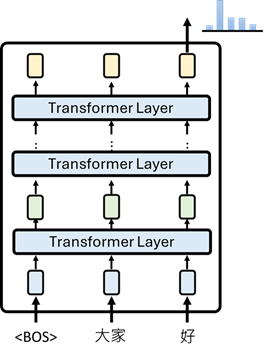

In [ ]:
inputs = tokenizer.encode("大家好", return_tensors="pt")
print("编码后的 Token IDs：", inputs)
outputs = model(inputs, output_hidden_states=True) # output_hidden_states=True 才会回传每一层的 representation (hidden states)
hidden_states = outputs.hidden_states
# hidden_states[0] -> embedding （把 token 转成 token embedding 的结果)
# hidden_states[1] ~ hidden_states[N] -> 每一层 Transformer block 的输出
print(f"一共拿到 {len(hidden_states)} 层 representation（包含 token embedding）。")
# 列出每层输出的形状
for idx, h in enumerate(hidden_states):
    print(f"Layer {idx:2d} 输出形状: {h.shape}")
    # h.shape = [batch_size, seq_len, hidden_size]
    # batch_size → 一次处理的句子数
    # sequence_length → 句子被切成多少 token
    # hidden_size → 每个 token 的向量长度
print("\n=== Token Embedding 输出 ===")
print(hidden_states[0])
print("\n=== 第一个 Transformer Layer 的输出 ===")
print(hidden_states[1])

编码后的 Token IDs： tensor([[99466, 52801]])
一共拿到 29 层 representation（包含 token embedding）。
Layer  0 输出形状: torch.Size([1, 2, 1024])
Layer  1 输出形状: torch.Size([1, 2, 1024])
Layer  2 输出形状: torch.Size([1, 2, 1024])
Layer  3 输出形状: torch.Size([1, 2, 1024])
Layer  4 输出形状: torch.Size([1, 2, 1024])
Layer  5 输出形状: torch.Size([1, 2, 1024])
Layer  6 输出形状: torch.Size([1, 2, 1024])
Layer  7 输出形状: torch.Size([1, 2, 1024])
Layer  8 输出形状: torch.Size([1, 2, 1024])
Layer  9 输出形状: torch.Size([1, 2, 1024])
Layer 10 输出形状: torch.Size([1, 2, 1024])
Layer 11 输出形状: torch.Size([1, 2, 1024])
Layer 12 输出形状: torch.Size([1, 2, 1024])
Layer 13 输出形状: torch.Size([1, 2, 1024])
Layer 14 输出形状: torch.Size([1, 2, 1024])
Layer 15 输出形状: torch.Size([1, 2, 1024])
Layer 16 输出形状: torch.Size([1, 2, 1024])
Layer 17 输出形状: torch.Size([1, 2, 1024])
Layer 18 输出形状: torch.Size([1, 2, 1024])
Layer 19 输出形状: torch.Size([1, 2, 1024])
Layer 20 输出形状: torch.Size([1, 2, 1024])
Layer 21 输出形状: torch.Size([1, 2, 1024])
Layer 22 输出形状: torch.Size([1, 2, 

## 比较不同输入的representation

In [ ]:
def get_embedding(text, layer_num):
    """
    输入一句话文字，打印出模型某一个 layer 的每个 token 的 embedding。
    """
    print(f"\n=== {text} ===")
    inputs = tokenizer.encode(text, return_tensors="pt", add_special_tokens=False)
    #print(inputs)
    outputs = model(inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    hidden_states_layer = hidden_states[layer_num]
    tokens = tokenizer.tokenize(text)
    seq_length = len(tokens)
    for t in range(0,seq_length):
      print(tokens[t], ":", hidden_states_layer[0][t])
layer_num = 10 # 0: token embedding, >0: contextualized token embedding
get_embedding("How about you?", layer_num )
get_embedding("How are you?", layer_num )
get_embedding("Nice to meet you.", layer_num )


=== How about you? ===
How : tensor([ 15.9040, 324.8043,  -1.7652,  ...,  -0.7231,  -4.0249,  -4.0710],
       grad_fn=<SelectBackward0>)
Ġabout : tensor([-2.7042,  3.7393, -0.4405,  ..., -0.1765, -0.3508,  0.2472],
       grad_fn=<SelectBackward0>)
Ġyou : tensor([-2.0890,  2.8774,  0.1914,  ..., -0.8149, -0.0239, -0.5567],
       grad_fn=<SelectBackward0>)
? : tensor([ 0.0722,  3.1221, -0.1942,  ...,  0.1744,  0.1650,  0.1089],
       grad_fn=<SelectBackward0>)

=== How are you? ===
How : tensor([ 15.9040, 324.8043,  -1.7652,  ...,  -0.7231,  -4.0249,  -4.0710],
       grad_fn=<SelectBackward0>)
Ġare : tensor([-0.8420,  4.4926,  0.0424,  ..., -1.3497, -1.3925, -1.5181],
       grad_fn=<SelectBackward0>)
Ġyou : tensor([-0.0685,  3.1279, -0.6940,  ..., -0.8235, -0.0650,  0.0624],
       grad_fn=<SelectBackward0>)
? : tensor([ 1.0939,  3.8958,  0.2789,  ..., -0.9554, -0.3564,  0.2150],
       grad_fn=<SelectBackward0>)

=== Nice to meet you. ===
Nice : tensor([ 19.9340, 400.4738,  -2.24

tensor([[   40, 29812,   458, 23268,   369, 17496,    13]])
tensor([[  785,  2813,   429,  7117,   601,   279, 22271,   323,  6553, 23527,
            82,   374, 23268,    13]])


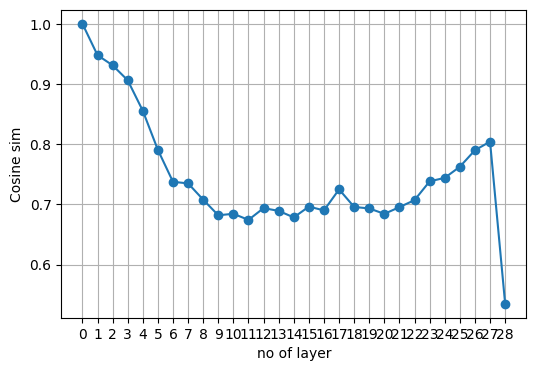

In [ ]:
#比较 sentence1 和 sentence2 中的 "apple" ，在不同层的相似程度

sentence1 = "I ate an apple for breakfast."
idx1 = 3 # apple 在 "I ate an apple for breakfast." 的位置
#[40, 29812, 458, 23268,  369, 17496,  13]
sentence2 = "The company that brought us the iPad and AirPods is apple."
idx2 = 12 # apple 在 "The tech company apple announced its earnings yesterday." 的位置
#[785,  2813,   429,  7117,   601,   279, 22271,   323,  6553, 23527, 82,   374, 23268,    13]

inputs1 = tokenizer.encode(sentence1, return_tensors="pt")
print(inputs1)
outputs1 = model(inputs1, output_hidden_states=True)
hidden_states1 = outputs1.hidden_states

inputs2 = tokenizer.encode(sentence2, return_tensors="pt")
print(inputs2)
outputs2 = model(inputs2, output_hidden_states=True)
hidden_states2 = outputs2.hidden_states

# 计算每一层的 cosine_similarity
distances = []
for l in range(len(hidden_states)):
    vec1 = hidden_states1[l][0][idx1].detach().numpy()  # 句子1 中 '▁apple' 的向量
    vec2 = hidden_states2[l][0][idx2].detach().numpy()  # 句子2 中 '▁apple' 的向量
    cos_sim = cosine_similarity([vec1], [vec2])[0]
    #print(cos_sim)
    distances.append(cos_sim)

# 绘制距离随层数变化图
layers = list(range(len(distances)))
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(layers, distances, marker='o')
plt.xticks(layers)
plt.xlabel("no of layer")
plt.ylabel("Cosine sim")
plt.grid(True)
plt.show()

sentence[0] tensor([[   40, 29812,   458, 23268,   369, 17496,    13]])
sentence[1] tensor([[ 7941, 40678,   458, 23268,  4349,   369, 42749,    13]])
sentence[2] tensor([[  785, 13014, 14538, 23268,  7228,  1181, 50434, 23681,    13]])
sentence[3] tensor([[ 5842,  2003,   279, 13014, 14538, 23268, 10457,  1181,   501, 12167,
            13]])


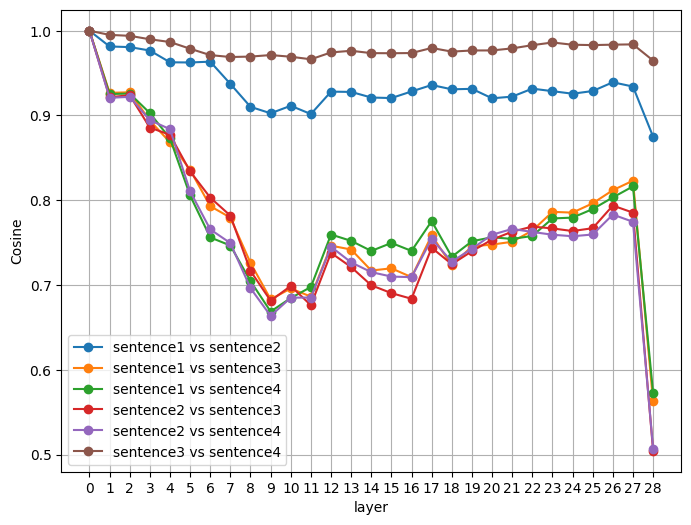

In [ ]:
# 定义 4 个句子：前两句是「可食用的 apple」，后两句是「Apple 公司」
sentences = [
    "I ate an apple for breakfast.", # 可食用的 apple 示例 1
    "She baked an apple pie for dessert.", # 可食用的 apple 示例 2
    "The tech giant apple announced its quarterly earnings.", # Apple 公司示例 1
    "Last week the tech giant apple revealed its new iPhone." # Apple 公司示例 2
]
num_sentences = 4
# 编码并取得所有层的 hidden_states
hidden_states_batch = []
for i in range(num_sentences):
  inputs = tokenizer.encode(sentences[i], return_tensors="pt")
  print(f"sentence[{i}]", inputs)
  outputs = model(inputs, output_hidden_states=True)
  hidden_states_batch.append(outputs.hidden_states)
# 每句中 'apple' 的索引位置
idxs = [3, 3, 3, 5]
# 为每一对句子组合准备相似度存储结构
pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
sim_dict = {pair: [] for pair in pairs}
# 逐层计算每对组合的 Cosine 相似度
num_layer = 28
for l in range(num_layer+1):
    for (i, j) in pairs:
        vec_i = hidden_states_batch[i][l][0][idxs[i]].detach().numpy()
        vec_j = hidden_states_batch[j][l][0][idxs[j]].detach().numpy()
        sim = cosine_similarity([vec_i], [vec_j])[0]
        sim_dict[(i, j)].append(sim)
# 绘制每对组合随层数变化的相似度曲线
layers = list(range(len(hidden_states))) # 0 = embedding 层
plt.figure(figsize=(8, 6))
for (i, j), sims in sim_dict.items():
    label = f"sentence{i+1} vs sentence{j+1}"
    plt.plot(layers, sims, marker='o', label=label)
plt.xticks(layers)
plt.xlabel("layer")
plt.ylabel("Cosine")
plt.legend()
plt.grid(True)
plt.show()

## 通过 logits 解析 representation

在典型的语言模型使用中，输入的 token 会经过多层 Transformer layer 的运算，每一层都会产生一组 representation。我们通常只取最后一层的表示，通过 Unembedding (LM head) 将其转换到词汇表大小的空间，得到每个 token 的 logit，最后再经由 softmax 得到下一个 token 的概率分布。换言之，我们平常只关注「最后的输出层」。

Logit lens 的核心想法是：其实不一定要等到最后一层，我们可以在每一层的 representation 上套用相同的 Unembedding，来观察如果「此时就直接拿来预测 token」，模型会认为最有可能的输出是什么。这样做就像替每一层「戴上一副眼镜」来观察：模型在中间层时，脑中已经倾向哪些词汇？随着层数加深，模型又是如何逐步收敛到最终答案的呢？

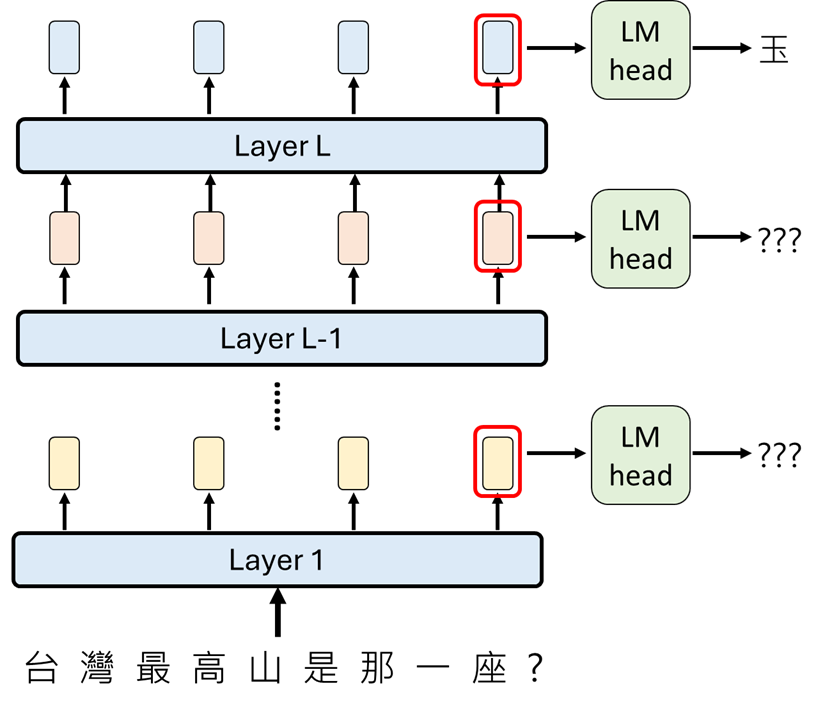

In [ ]:
text = "今天天气"
input_ids = tokenizer_gemma.encode(text, return_tensors="pt")
outputs = model_gemma(input_ids, output_hidden_states=True)
hidden_states = outputs.hidden_states
print(f"一共拿到 {len(hidden_states)} 层 representation （包含 token embedding）。")

for l in range(len(hidden_states)):
    # 用该层 hidden state 经过 lm_head 得到 logits
    logits = model_gemma.lm_head(hidden_states[l])   # [batch, seq_len, vocab_size]

    # 取最后一个 token 的 logits
    last_token_logits = logits[0, -1]  # [vocab_size]

    # 选分数最高的 token
    next_token_id = torch.argmax(last_token_logits)

    # 转成字
    print(f"Layer {l:2d} → {tokenizer_gemma.decode(next_token_id)}")

一共拿到 27 层 representation （包含 token embedding）。
Layer  0 → 天气
Layer  1 →  and
Layer  2 →  and
Layer  3 →  M
Layer  4 → �
Layer  5 → �
Layer  6 → �
Layer  7 → �
Layer  8 → �
Layer  9 → �
Layer 10 → �
Layer 11 → �
Layer 12 → �
Layer 13 → �
Layer 14 → �
Layer 15 → �
Layer 16 → �
Layer 17 → �
Layer 18 → �
Layer 19 → �
Layer 20 → �
Layer 21 → �
Layer 22 → �
Layer 23 → �
Layer 24 → �
Layer 25 → �
Layer 26 → 晴


In [ ]:
?model_gemma.lm_head

## 实际用法

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Write a poem on SWUFE, a university in China."},
]

inputs = tokenizer_gemma.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
)

with torch.inference_mode():
    outputs = model_gemma.generate(**inputs, max_new_tokens=64)

print(tokenizer_gemma.batch_decode(outputs, skip_special_tokens=True))

['user\nYou are a helpful assistant.\n\nWrite a poem on SWUFE, a university in China.\nmodel\nOkay, here’s a poem about SWUFE, a prominent university in China, aiming for a balance of appreciation and a touch of its unique history:\n\n**SWUFE: A Beacon in the East**\n\nIn mountains high, a storied grace,\nSWUFE stands, a timeless space.\n']
